## Линейная регрессия: переобучение и регуляризация

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

В датасете __"bikes_rent.csv"__ по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день.

In [2]:
df = pd.read_csv(r'C:\Users\Xiaomi\Desktop\Data Science\2. Обучение на размеченных данных\Jupyter Notebook\3. Линейная регрессия - переобучение и регуляризация.csv')

In [3]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (целевая функция)

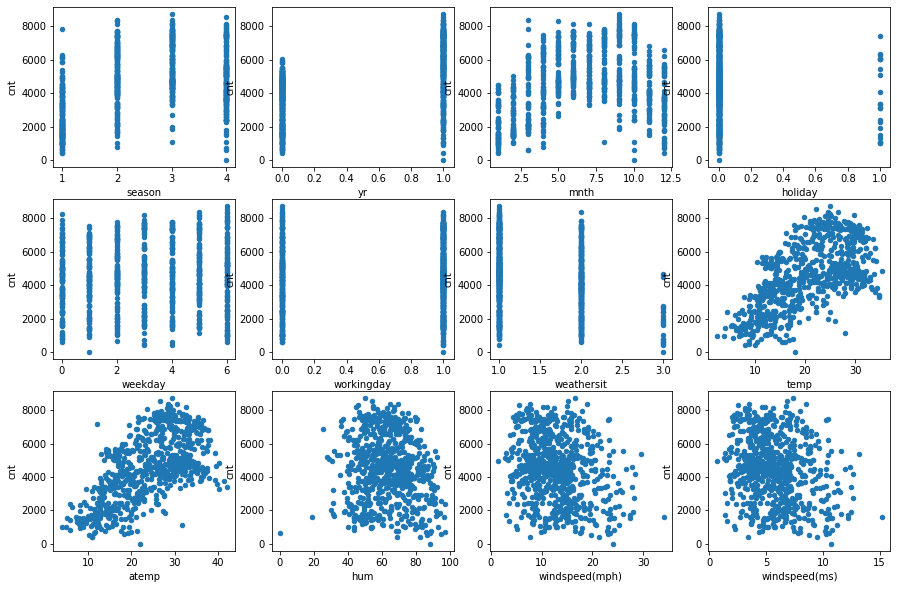

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(x=feature, y="cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

**Из графиков видно**, что 
1. Характер зависимости числа прокатов от месяца стремится к нормальному распределению по месяцам, с математическим ожиданием соответствующим середине лета - июнь-июль.
2. Число прокатов скорее всего зависит линейно признаков temp, atemp

**Оценка уровеня линейной зависимости между признаками и целевой переменной.**

Хорошей мерой линейной зависимости между двумя векторами является __корреляция Пирсона__. 

В pandas ее можно посчитать с помощью двух методов датафрейма: corr и corrwith. Метод __`df.corr`__ вычисляет матрицу корреляций всех признаков из датафрейма. Методу __`df.corrwith`__ нужно подать еще один датафрейм в качестве аргумента, и тогда он посчитает попарные корреляции между признаками из df и этого датафрейма.

In [4]:
# Корреляции всех признаков, с целевой переменной:

a = df[df.columns[:-1]] # DataSet всех признаков
b = df['cnt'] # DataSet целевой переменной

correlation = a.corrwith(other=b, axis=0, drop=False, method='pearson')

print(correlation)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому имеет смысл также посчитать корреляции между вещественными признаками.

In [6]:
# Попарные корреляции между вещественными признаками

a = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]
correlation = a.corr(method='pearson', min_periods=1)

In [7]:
correlation

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях должны стоять единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Этот факт негативно сказывается на обучении линейной модели.

Оценить масштаб признаков и доли единиц у бинарных признаков можно по среднему признаков.

In [8]:
# Средние признаков
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы необходимо нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

В представленных данных один признак дублирует другой, и есть два очень похожих признака. Проиллюстрируем, как бы происходило обучение модели, если бы этого не заметили.

В начале проведится масштабирование, или стандартизацию признаков: из каждого признака вычитается его среднее и делится на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, необходимо перемешать выборку, что потребуется для кросс-валидации.

In [8]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [9]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Обучение линейной регрессии на представленных данных.

In [10]:
from sklearn.linear_model import LinearRegression

In [11]:
# Создание объекта - модели линейной регресии
linear_regressor = LinearRegression()

# Обучение модели линейной регрессии
linear_regressor.fit(X=X, y=y, sample_weight=None)

# Вывод пар данных (название признака: вес)
print('Коэффициенты соотвествующих признаков:\n')
for  feature, coeff in zip( df.columns[:-1], linear_regressor.coef_):
    print("%-20s%.3f" % (feature, coeff))
    
# Свободный член функции, вычисленной моделью
print('\nСвободный член функции: ', round(linear_regressor.intercept_, 3))

Коэффициенты соотвествующих признаков:

season              570.868
yr                  1021.964
mnth                -141.302
holiday             -86.764
weekday             137.229
workingday          56.388
weathersit          -330.232
temp                367.475
atemp               585.556
hum                 -145.608
windspeed(mph)      12458830091266.607
windspeed(ms)       -12458830091465.062

Свободный член функции:  4504.354


Видно, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Если посмотреть на аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов

$w = (X^TX)^{-1} X^T y$.

то понятно, что если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой temp-atemp чуть менее коррелирующих переменных такого не произошло, однако всегда стоит внимательно следить за коэффициентами при похожих признаках.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

In [12]:
from sklearn.linear_model import Lasso, Ridge

In [13]:
# Линейная модель с L1-регуляризацией

# Создание объекта - модели линейной регресии
lasso_regressor = Lasso(random_state = 12)

# Обучение модели линейной регрессии
lasso_regressor.fit(X=X, y=y)

# Вывод пар данных (название признака: вес)
print('Коэффициенты соотвествующих признаков:\n')
for coeff, feature in zip(lasso_regressor.coef_, df.columns[:-1]):
    print("%-20s%.3f" % (feature, coeff))
    
# Свободный член функции, вычисленной моделью
print('\nСвободный член функции: ', round(lasso_regressor.intercept_, 3))

Коэффициенты соотвествующих признаков:

season              560.242
yr                  1019.463
mnth                -128.731
holiday             -86.153
weekday             137.348
workingday          55.212
weathersit          -332.370
temp                376.363
atemp               576.531
hum                 -144.129
windspeed(mph)      -197.140
windspeed(ms)       -0.000

Свободный член функции:  4504.349


In [14]:
# Линейная модель с L2-регуляризацией

# Создание объекта - модели линейной регресии
ridge_regressor = Ridge(random_state = 13)

# Обучение модели линейной регрессии
ridge_regressor.fit(X=X, y=y)

# Вывод пар данных (название признака: вес)
print('Коэффициенты соотвествующих признаков:\n')
for coeff, feature in zip(ridge_regressor.coef_, df.columns[:-1]):
    print("%-20s%.3f" % (feature, coeff))
    
# Свободный член функции, вычисленной моделью
print('\nСвободный член функции: ', round(ridge_regressor.intercept_, 3))

Коэффициенты соотвествующих признаков:

season              563.065
yr                  1018.948
mnth                -131.873
holiday             -86.746
weekday             138.005
workingday          55.903
weathersit          -332.350
temp                386.458
atemp               566.347
hum                 -145.071
windspeed(mph)      -99.259
windspeed(ms)       -99.259

Свободный член функции:  4504.349


### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках.

Отобразим динамику изменения весов при увеличении коэффициента регуляризации $\alpha$.

In [15]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))


# Обучение модели и получение коэффициентов для coefs_lasso
for i in range(alphas.shape[0]):
    lasso_regressor = Lasso(alpha=alphas[i])
    lasso_regressor.fit(X=X, y=y)
    for ind, coeff in enumerate(lasso_regressor.coef_):
        coefs_lasso[i][ind] = coeff

        
# Обучение модели и получение коэффициентов для coefs_ridge
for i in range(alphas.shape[0]):
    ridge_regressor = Ridge(alpha=alphas[i])
    ridge_regressor.fit(X=X, y=y)
    for ind, coeff in enumerate(ridge_regressor.coef_):
        coefs_ridge[i][ind] = coeff

Визуализация динамики весов при увеличении параметра регуляризации:

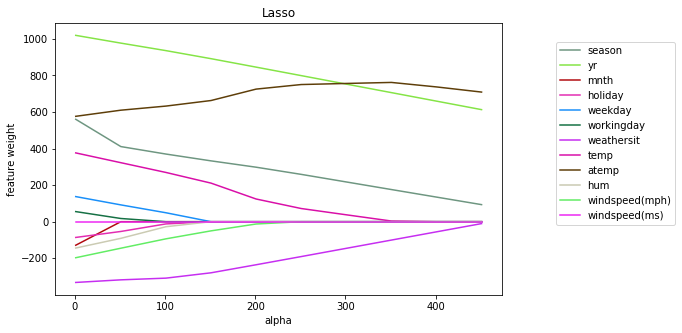

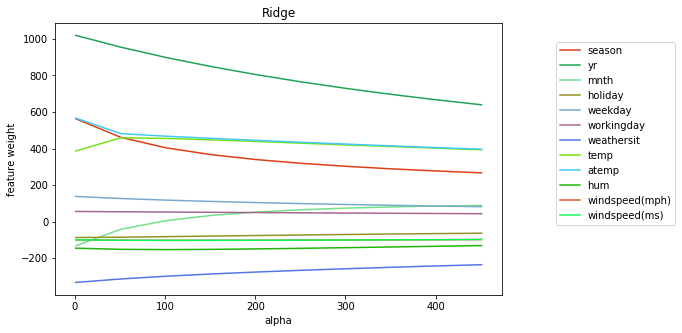

In [16]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

1. Регуляризатор Lasso агрессивнее уменьшает веса при одном и том же коэффициенте регуляризации alpha, чем Ridge
2. Если alpha сделать очень большим, большинство весов сойдутся в нуле, поскольку Lasso стремится занулить менее информативные веса
3. Исходя из данных графика и таблиц коэффициентов ниже, виддно: Lasso исключает один из признаков windspeed при любых значениях alpha > 0 (коэффициент стремится к нулю (-2.80496527e-08)), Ridge приравнивает значения коэффициентов одинаковых признаков при любых значениях alpha > 0.
4. Регуляризатор Lasso подходит для отбора неинформативных признаков, поскольку он зануляет их веса.

In [17]:
df.columns[10:12]

Index(['windspeed(mph)', 'windspeed(ms)'], dtype='object')

In [18]:
coefs_lasso[:,10:12]

array([[-1.97139689e+02, -2.80496527e-08],
       [-1.45066095e+02, -2.29876665e-08],
       [-9.37749037e+01, -2.41641619e-08],
       [-5.01551472e+01, -2.62774544e-08],
       [-1.26461769e+01, -2.78783243e-08],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00]])

In [19]:
coefs_ridge[:,10:12]

array([[ -99.25944108,  -99.25944115],
       [-101.62731482, -101.62731483],
       [-102.10167084, -102.10167084],
       [-102.00537592, -102.00537593],
       [-101.58638458, -101.58638458],
       [-100.96471143, -100.96471143],
       [-100.20862041, -100.20862041],
       [ -99.36066117,  -99.36066117],
       [ -98.44906427,  -98.44906427],
       [ -97.49343362,  -97.49343362]])

Далее будем работать с Lasso.

Видно, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Необходимо выбрать наилучшее alpha. 

Для этого, __во-первых__, необходима метрика качества. Используем в качестве метрики сам оптимизируемый функционал метода наименьших квадратов - Mean Square Error.

__Во-вторых__, необходимо понять, на каких данных определеять метрику. Нельзя выбирать alpha по значению MSE на обучающей выборке, поскольку в таком случае не получится оценить, как модель будет делать предсказания на новых для нее данных. Если выбрать одно разбиение выборки на обучающую и тестовую (holdout), то произойдет настройка на конкретные "новые" данные, и может вновь произойти переобучение. Поэтому необходимо делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ частей, или блоков, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

In [20]:
from sklearn.linear_model import LassoCV


Выбранное значение параметра регуляризации =  6

Коэффициенты соотвествующих признаков:

season              532.019
yr                  1015.060
mnth                -100.040
holiday             -83.294
weekday             132.504
workingday          51.557
weathersit          -330.560
temp                370.680
atemp               581.397
hum                 -140.007
windspeed(mph)      -191.771
windspeed(ms)       -0.000


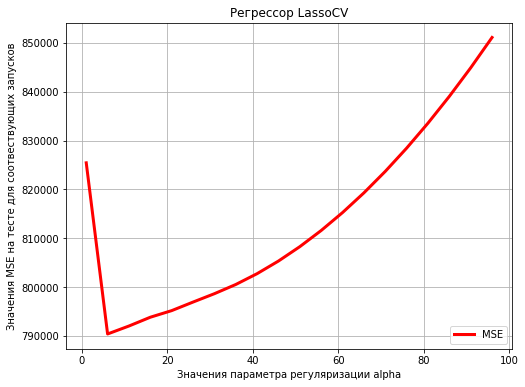

In [21]:
# Обучение регрессора LassoCV на всех параметрах регуляризации из alpha

alphas = np.arange(1, 100, 5)

cv = 3
lassocv_regressor = LassoCV(alphas=alphas, cv=cv)
lassocv_regressor.fit(X=X, y=y)
predictions = lassocv_regressor.predict(X=X)

mse = lassocv_regressor.mse_path_ # Содержит значения MSE на тесте для соотвествующих запусков
regressor_alpha = lassocv_regressor.alpha_ # Содержит выбранное значение параметра регуляризации
regressor_alphas = lassocv_regressor.alphas_ # Содержит все значения параметра регуляризации
coeff = lassocv_regressor.coef_ # Содержит обученные веса, соотвествующие alpha_

# print('MSE = ', mse)
# print('\nВсе значения параметра регуляризации = ', regressor_alphas)
print('\nВыбранное значение параметра регуляризации = ', regressor_alpha)

# Вывод пар данных (название признака: вес) для обученного вектора коэффициентов
print('\nКоэффициенты соотвествующих признаков:\n')
for feature, coeff in zip(df.columns[:-1], coeff):
    print("%-20s%.3f" % (feature, coeff))

# Построение график усредненного по строкам MSE в зависимости от alpha.    
mean_mse = [np.mean(mse[i,:]) for i in range(alphas.shape[0])]

plt.figure(figsize=(8, 6))
plt.plot(regressor_alphas, mean_mse, label="MSE", color='red', linewidth=3)
plt.legend(loc="lower right")
plt.xlabel("Значения параметра регуляризации alpha")
plt.ylabel("Значения MSE на тесте для соотвествующих запусков")
plt.title("Регрессор LassoCV")
plt.grid(True)
plt.show()

Рассмотрим траектории MSE, соответствующие отдельным блокам выборки


Значения alpha, соответствующие минимумам MSE на каждом разбиении =  [41, 6, 1]


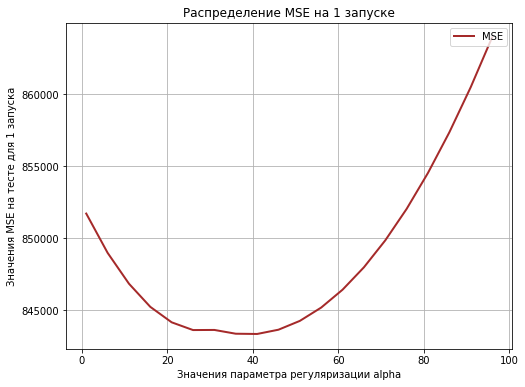

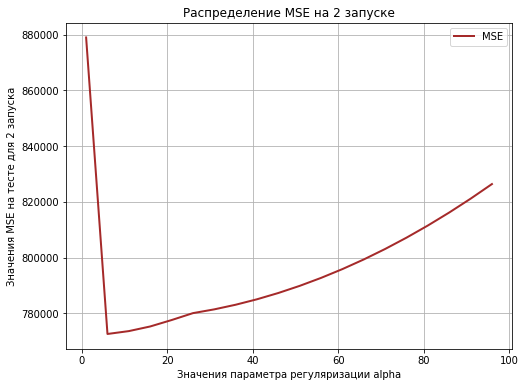

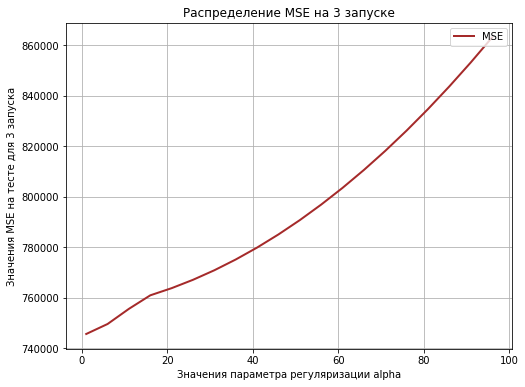

In [32]:
min_mse_alpha = list()
for j in range(cv):
    i, = np.where(mse[:,j] == np.min(mse[:,j]))
    min_mse_alpha.append(regressor_alphas[i][0])


print('\nЗначения alpha, соответствующие минимумам MSE на каждом разбиении = ', min_mse_alpha)


for j in range(3):
    plt.figure(figsize=(8, 6))
    plt.plot(regressor_alphas, mse[:,j], label="MSE", color='brown', linewidth=2)
    plt.legend(loc="upper right")
    plt.xlabel("Значения параметра регуляризации alpha")
    plt.ylabel(f"Значения MSE на тесте для {j+1} запуска")
    plt.title(f"Распределение MSE на {j+1} запуске")
    plt.grid(True)
    plt.show()

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что происходит настройка на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации происходит выбор "среднего", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

1. Признаки yr, atemp, season, temp имеют наибольшие коэффициенты. Для atemp и temp присутствует линейная зависимость cnt от этих признаков. Логично, что чем выше значения этих параметров, тем больше людей захотят взять велосипеды. Однако, существует пороговая величина, после достижения которой будет наблюдаться обратная зависимость (слишком жарко). Для yr виден рост людей, желающих взять велосипеды, однако выборка из двух лет слишком мала, чтобы делать выводы. Для season линейного роста нет. Здесь наблюдается скорее нормальное распределение относительно середины лета.
2. Признаки weathersit, windspeed(mph), hum обладают наибольшими по модулю отрицательными коэффициентами. Для weathersit видна убывающая линейная зависимость и это логично. windspeed(mph) не обладает четкой линейной зависимостью. Относительно влажности (hum) можно сказать, что есть убывающая линейная зависимость после некоторого порогового значения. Относительно логичности убывающей линейной зависимости количества желлающих взять велосипед с ростом влажности не все однозначно: сама по себе влажность малоинформативна без учета ветра и температуры.
3. windspeed(ms) является линейно зависимым признаком от windspeed(mph), поэтому его необходимо исключать из модели. Он никак не влияет на спрос на велосипеды, поскольку является производной от windspeed(mph).